In [1]:
import os
import sys

sys.path.append("../code/.")

import IPython
import ipywidgets as widgets
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from ipywidgets import interact, interactive
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from utils import *

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

### Announcements

- Homework 3 is due on Oct 2nd.
- Please see Piazza about midterm conflict survey

### (iClicker) Exercise 6.2 

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements which are TRUE.**

- (A) Whe creating a `OneHotEncoder` setting `handle_unknown="ignore"` would treat all unknown categories equally. 
- (B) As you increase the value for `max_features` hyperparameter of `CountVectorizer` the training score is likely to go up. 
- (C) Suppose you are encoding text data using `CountVectorizer`. If you encounter a word in the validation or the test split that's not available in the training data, we'll get an error. 
- (D) In the code below, inside `cross_validate`, each fold might have slightly different number of features (columns) in the fold.

```
pipe = (CountVectorizer(), SVC())
cross_validate(pipe, X_train, y_train)
```

## Learning outcomes

From this lecture, students are expected to be able to: 

- Explain the general intuition behind linear models;
- Explain how `predict` works for linear regression;
- Use `scikit-learn`'s `Ridge` model; 
- Demonstrate how the `alpha` hyperparameter of `Ridge` is related to the fundamental tradeoff; 
- Explain the difference between linear regression and logistic regression;   
- Use `scikit-learn`'s `LogisticRegression` model and `predict_proba` to get probability scores
- Explain the advantages of getting probability scores instead of hard predictions during classification; 
- Broadly describe linear SVMs 
- Explain how can you interpret model predictions using coefficients learned by a linear model; 
- Explain the advantages and limitations of linear classifiers. 

**Linear models** is a fundamental and widely used class of models. They are called **linear** because they make a prediction using a **linear function** of the input features.  

We will talk about three linear models: 
- Linear regression 
- Logistic regression
- Linear SVM (brief mention)

### Linear regression 

- A very popular statistical model and has a long history.  
- Imagine a hypothetical regression problem of predicting weight of a snake given its length. 

In [2]:
np.random.seed(7)
n = 100
X_1 = np.linspace(0, 2, n) + np.random.randn(n) * 0.01
X = pd.DataFrame(X_1[:, None], columns=["length"])

y = abs(np.random.randn(n, 1)) * 3 + X_1[:, None] * 5 + 0.2
y = pd.DataFrame(y, columns=["weight"])
snakes_df = pd.concat([X, y], axis=1)

In [3]:
train_df, test_df = train_test_split(snakes_df, test_size=0.2, random_state=77)

X_train = train_df[["length"]].values
y_train = train_df["weight"].values
X_test = test_df[["length"]].values
y_test = test_df["weight"].values
train_df.head()

,length,weight
73,1.489130,10.507995
53,1.073233,7.658047
80,1.622709,9.748797
49,0.984653,9.731572
23,0.484937,3.016555


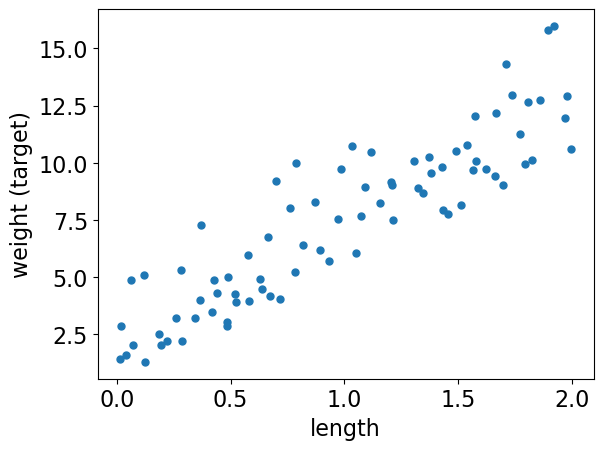

In [4]:
plt.plot(X_train, y_train, ".", markersize=10)
plt.xlabel("length")
plt.ylabel("weight (target)");

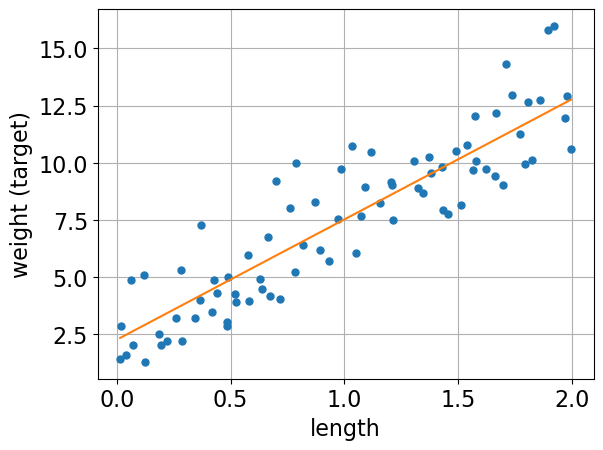

In [5]:
from sklearn.linear_model import Ridge

r = Ridge()
r.fit(X_train, y_train)
plt.plot(X_train, y_train, ".", markersize=10)
# Plot regression line
grid = np.linspace(min(X_train)[0], max(X_train)[0], 1000)
grid = grid.reshape(-1, 1)
plt.plot(grid, r.predict(grid))
plt.grid(True)
plt.xlabel("length")
plt.ylabel("weight (target)");

### How are we making predictions? 

In [6]:
snake_length = 0.75
r.predict([[snake_length]])

array([6.20683258])

- Given a feature value $x_1$ and learned coefficient $w_1$ and intercept $b$, we can get the prediction $\hat{y}$ with the following formula:
$$\hat{y} = w_1x_1 + b$$

In [7]:
r.coef_, r.intercept_

(array([5.26370005]), 2.2590575478171857)

### Generalizing to more features
For more features, the model is a higher dimensional hyperplane and the general prediction formula looks as follows: 

$\hat{y} =$ <font color="red">$w_1$</font> <font color="blue">$x_1$ </font> $+ \dots +$ <font color="red">$w_d$</font> <font color="blue">$x_d$</font> + <font  color="green"> $b$</font>

where, 
- <font  color="blue"> ($x_1, \dots, x_d$) are input features </font>
- <font  color="red"> ($w_1, \dots, w_d$) are coefficients or weights </font> (learned from the data)
- <font  color="green"> $b$ is the bias which can be used to offset your hyperplane </font> (learned from the data)

### `Ridge`

- `scikit-learn` has a model called `LinearRegression` for linear regression. 
- But if we use this "vanilla" version of linear regression, it may result in large coefficients and unexpected results. 
- So instead of using `LinearRegression`, we will always use another linear model called `Ridge`, which is a linear regression model with a complexity hyperparameter `alpha`.

In [8]:
from sklearn.linear_model import LinearRegression  # DO NOT USE IT IN THIS COURSE
from sklearn.linear_model import Ridge  # USE THIS INSTEAD

#### Hyperparameter `alpha` of `Ridge`

- Ridge has hyperparameters just like the rest of the models we learned.
- The alpha hyperparameter is what makes `Ridge` different from vanilla `LinearRegression`. 
- Similar to the other hyperparameters that we saw, `alpha` controls the fundamental tradeoff.


> If we set alpha=0 that is the same as using LinearRegression.

### (iClicker) Exercise 7.1 

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements which are TRUE.**

- (A) Increasing the hyperparameter `alpha` of `Ridge` is likely to decrease model complexity.
- (B) `Ridge` can be used with datasets that have multiple features.
- (C) With Ridge, we learn one coefficient per training example.
- (D) If you train a linear regression model on a 2-dimensional problem (2 features), the model will learn 3 parameters: one for each feature and one for the bias term. 

In [9]:
from sklearn.datasets import fetch_california_housing


california = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(
    california.data, california.target, test_size=0.2
)
pipe_ridge = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
pipe_ridge.fit(X_train, y_train)
coeffs = pipe_ridge.named_steps["ridge"].coef_

### Interpretation of coefficients 

- One of the main advantages of linear models is that they are relatively easy to interpret. 
- We have one coefficient per feature which kind of describes the role of the feature in the prediction according to the model.

There are two pieces of information in the coefficients based on

- Sign
- Magnitude

### Sign of the coefficients

In the example below, for instance: 
- MedInc (median income) has a **positive coefficient**
    - the prediction will be proportional to the feature value; as MedInc gets **bigger**, the median house value gets **bigger** 
- AveRooms (Average number of rooms) has a **negative coefficient**
    - the prediction will be inversely proportional to the feature value; as AveRooms gets **bigger**, the median house value gets **smaller**

In [10]:
pd.DataFrame(data=coeffs, index=california.feature_names, columns=["Coefficients"])

,Coefficients
MedInc,0.827039
HouseAge,0.117058
AveRooms,-0.265273
AveBedrms,0.307521
Population,-0.003194
AveOccup,-0.039498
Latitude,-0.895963
Longitude,-0.866110


### Importance of scaling 
- When you are interpreting the model coefficients, scaling is crucial. 
- If you do not scale the data, features with smaller magnitude are going to get coefficients with bigger magnitude whereas features with bigger scale are going to get coefficients with smaller magnitude.
- That said, when you scale the data, feature values become hard to interpret for humans!

### Logistic regression intuition 

- A linear model for **classification**. 
- Similar to linear regression, it learns weights associated with each feature and the bias. 
- It applies a **threshold** on the raw output to decide whether the class is positive or negative. 
- In this lecture we will focus on the following aspects of logistic regression.  
    - `predict`, `predict_proba` 
    - how to use learned coefficients to interpret the model

So a linear classifier is a linear function of the input `X`, followed by a threshold. 

\begin{equation}
\begin{split}
z =& w_1x_1 + \dots + w_dx_d + b\\
=& w^Tx + b
\end{split}
\end{equation}

$$\hat{y} = \begin{cases}
         1, & \text{if } z \geq r\\
         -1, & \text{if } z < r
\end{cases}$$

#### Components of a linear classifier

1. Input features ($x_1, \dots, x_d$)
2. Coefficients (weights) ($w_1, \dots, w_d$)
3. Bias ($b$ or $w_0$) (can be used to offset your hyperplane)
4. Threshold ($r$)

In our example before, we assumed $r=0$ and $b=0$.

In [11]:
cities_df = pd.read_csv("../data/canada_usa_cities.csv")
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
X_train, y_train = train_df.drop(columns=["country"]).values, train_df["country"].values
X_test, y_test = test_df.drop(columns=["country"]).values, test_df["country"].values

cols = train_df.drop(columns=["country"]).columns

### Decision boundary of logistic regression

- The decision boundary of logistic regression is a **hyperplane** dividing the feature space in half. 

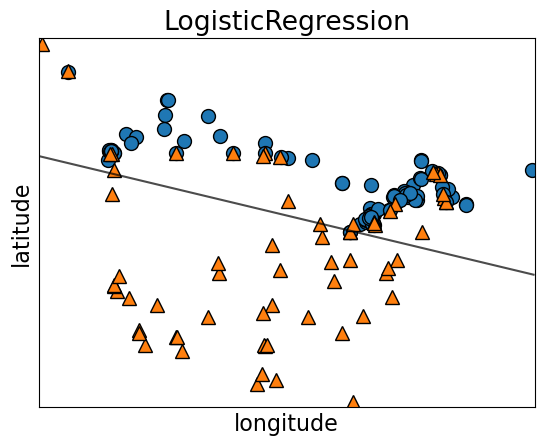

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
mglearn.plots.plot_2d_separator(lr, X_train, fill=False, eps=0.5, alpha=0.7)
plt.title(lr.__class__.__name__)
plt.xlabel("longitude")
plt.ylabel("latitude");

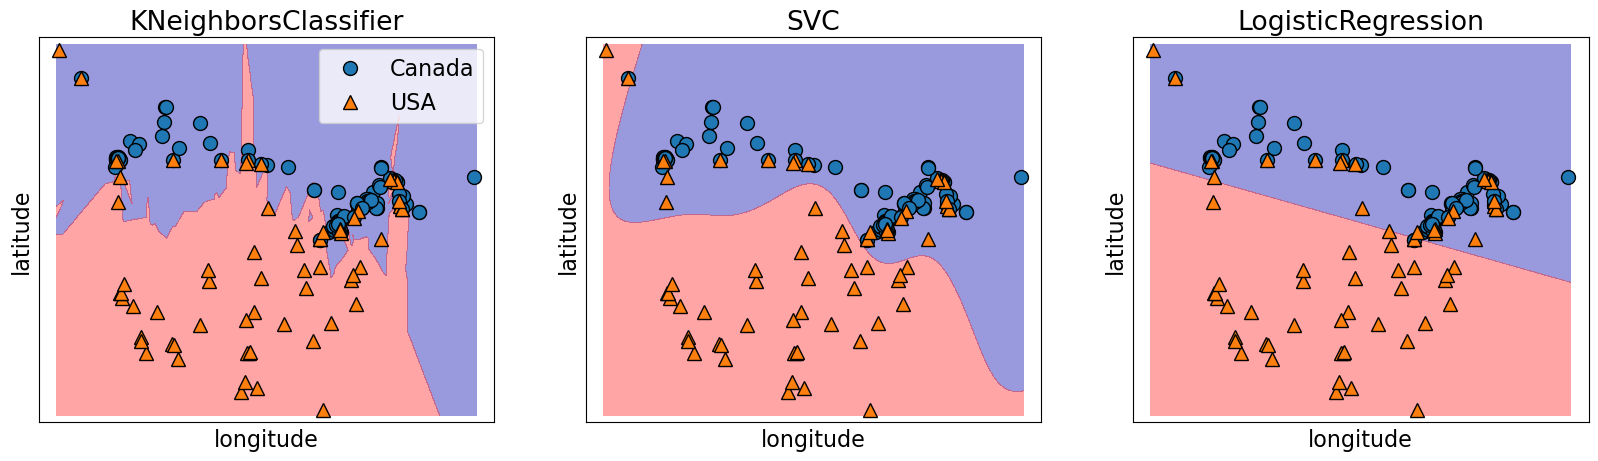

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for model, ax in zip(
    [KNeighborsClassifier(), SVC(gamma=0.01), LogisticRegression()], axes
):
    clf = model.fit(X_train, y_train)
    mglearn.plots.plot_2d_separator(
        clf, X_train, fill=True, eps=0.5, ax=ax, alpha=0.4
    )
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, ax=ax)
    ax.set_title(clf.__class__.__name__)
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
axes[0].legend();

### Main hyperparameter of logistic regression 

- `C` is the main hyperparameter which controls the fundamental trade-off.
- We won't really talk about the interpretation of this hyperparameter right now. 
- At a high level, the interpretation is similar to `C` of SVM RBF
    - smaller `C` $\rightarrow$ might lead to underfitting
    - bigger `C` $\rightarrow$ might lead to overfitting

### `predict_proba`

- So far in the context of classification problems, we focused on getting "hard" predictions. 
- Very often it's useful to know "soft" predictions, i.e., how confident the model is with a given prediction.  
- For most of the `scikit-learn` classification models we can access this confidence score or probability score using a method called `predict_proba`.  

In [14]:
example = X_test[0, :]
example

array([-64.8001,  46.098 ])

In [15]:
lr = LogisticRegression(random_state=123)
lr.fit(X_train, y_train)
lr.predict([example])  # hard prediction

array(['Canada'], dtype=object)

In [16]:
lr.predict_proba([example])  # soft prediction

array([[0.87848688, 0.12151312]])

- Because it's a probability, the sum of the entries for both classes should always sum to 1. 
- Since the probabilities for the two classes sum to 1, exactly one of the classes will have a score >=0.5, which is going to be our predicted class.  

#### How does logistic regression calculate these probabilities? 

- The weighted sum $w_1x_1 + \dots + w_dx_d + b$ gives us "raw model output".
- For linear regression this would have been the prediction.
- For logistic regression, you check the **sign** of this value.
  - If positive (or 0), predict $+1$; if negative, predict $-1$.
  - These are "hard predictions".

- You can also have "soft predictions", aka **predicted probabilities**. 
- To convert the raw model output into probabilities, instead of taking the sign, we apply the **sigmoid**.

#### The sigmoid function 
- The sigmoid function "squashes" the raw model output from any number to the range $[0,1]$ using the following formula, where $x$ is the raw model output. 
$$\frac{1}{1+e^{-x}}$$
- Then we can interpret the output as probabilities.

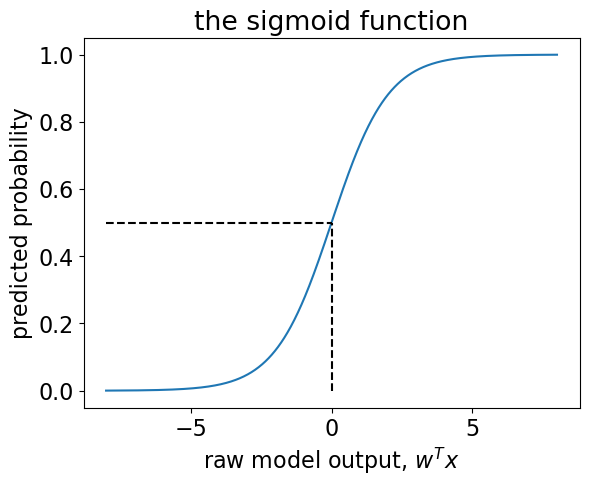

In [17]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
raw_model_output = np.linspace(-8, 8, 1000)
plt.plot(raw_model_output, sigmoid(raw_model_output))
plt.plot([0, 0], [0, 0.5], "--k")
plt.plot([-8, 0], [0.5, 0.5], "--k")
plt.xlabel("raw model output, $w^Tx$")
plt.ylabel("predicted probability")
plt.title("the sigmoid function");

In [18]:
data_dict = {
    "y": y_train[:12],
    "y_hat": lr.predict(X_train[:12]).tolist(),
    "probabilities": lr.predict_proba(X_train[:12]).tolist(),
}

In [19]:
pd.DataFrame(data_dict)

,y,y_hat,probabilities
0,Canada,Canada,"[0.7046068097086481, 0.2953931902913519]"
1,Canada,Canada,"[0.5630169062040135, 0.43698309379598654]"
2,Canada,Canada,"[0.8389680973255862, 0.16103190267441386]"
3,Canada,Canada,"[0.7964150775404333, 0.20358492245956678]"
4,Canada,Canada,"[0.9010806652340971, 0.09891933476590285]"
5,Canada,Canada,"[0.7753006388010791, 0.2246993611989209]"
6,USA,USA,"[0.030740704606528002, 0.969259295393472]"
7,Canada,Canada,"[0.6880304799160921, 0.3119695200839079]"
8,Canada,Canada,"[0.7891358587234145, 0.21086414127658554]"
9,USA,USA,"[0.006546969753885579, 0.9934530302461144]"


### (iClicker) Exercise 7.2 

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements which are TRUE.**

- (A) Increasing logistic regression's `C` hyperparameter increases model complexity.
- (B) The raw output score can be used to calculate the probability score for a given prediction. 
- (C) For linear classifier trained on $d$ features, the decision boundary is a $d-1$-dimensional hyperparlane.  
- (D) A linear model is likely to be uncertain about the data points close to the decision boundary. 

### Parametric vs Non-Parametric

- Parametric models
    - Model "size" does not depend on the amount of training data
    - Often faster to predict
    - Scales to large datasets
    - Examples: Linear/logistic regression
- Non-parametric models
    - Model "size" depends on the amount of training data
    - Becomes more complex as more training data is added
    - Examples: KNN, Decision tree with no depth

### Linear SVM 

- We have seen non-linear SVM with RBF kernel before. This is the default SVC model in `sklearn` because it tends to work better in many cases. 
- There is also a linear SVM. You can pass `kernel="linear"` to create a linear SVM. 

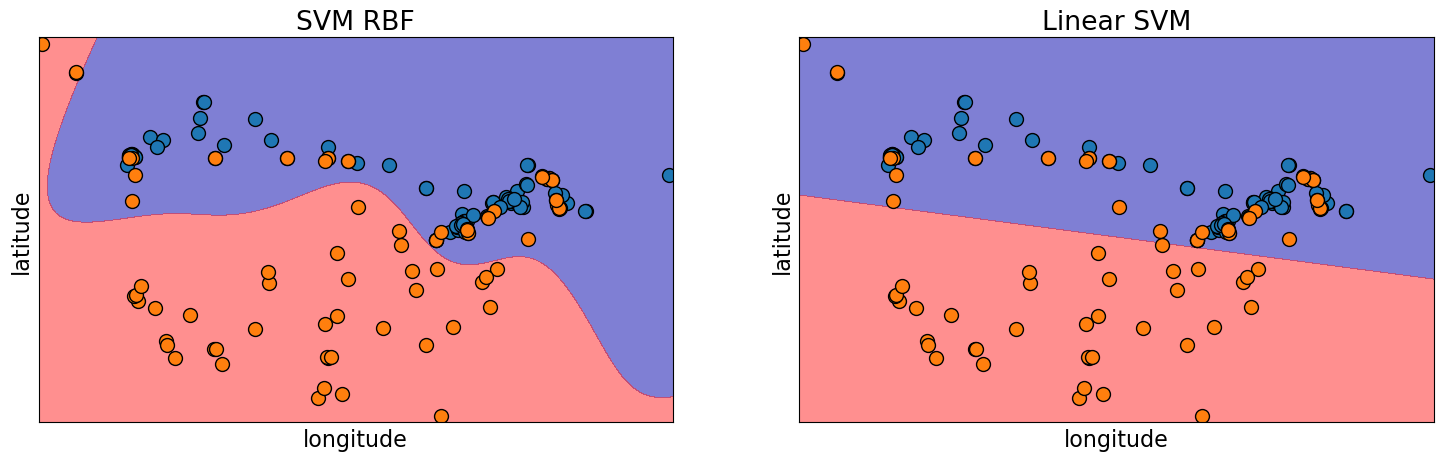

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
from matplotlib.colors import ListedColormap

for (model, ax) in zip([SVC(gamma=0.01), SVC(kernel="linear")], axes):
    mglearn.discrete_scatter(
        X_train[:, 0], X_train[:, 1], y_train, markers="o", ax=ax
    )
    model.fit(X_train, y_train)
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
    mglearn.plots.plot_2d_separator(
        model, X_train, fill=True, eps=0.5, ax=ax, alpha=0.5
    )

axes[0].set_title("SVM RBF")
axes[1].set_title("Linear SVM");

## Summary of linear models 

- Linear regression is a linear model for regression whereas logistic regression is a linear model for classification. 
- Both these models learn one coefficient per feature, plus an intercept. 

### Interpretation of coefficients in linear models 
- the $j$th coefficient tells us how feature $j$ affects the prediction
- if $w_j > 0$ then increasing $x_{ij}$ moves us toward predicting $+1$
- if $w_j < 0$ then increasing $x_{ij}$ moves us toward prediction $-1$
- if $w_j == 0$ then the feature is not used in making a prediction

### Limitations of linear models 

- Is your data "linearly separable"? Can you draw a hyperplane between these datapoints that separates them with 0 error. 
- If the training examples can be separated by a linear decision rule, they are **linearly separable**.
